In [43]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora, models
import string
from sklearn.feature_extraction.text import CountVectorizer
import ast
from nrclex import NRCLex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import svm 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import loguniform


### Feature Engineering Sentiment Analysis

In [2]:
df = pd.read_csv("preprocessed_data_new_negation.csv")

In [3]:
df["lemmatized_processed_text"] = df["lemmatized_processed_text"].apply(lambda x: ast.literal_eval(x))

In [5]:
df['clean_lemmatized_processed_text'] = [' '.join(map(str, l)) for l in df['lemmatized_processed_text']]

In [7]:
df['emotions'] = df['clean_lemmatized_processed_text'].apply(lambda x: NRCLex(x).affect_frequencies)

In [8]:
df = pd.concat([df.drop(['emotions'], axis = 1), df['emotions'].apply(pd.Series)], axis = 1)


In [10]:
df = df.fillna(0)

### Feature Engineering Dictionary + POS_Tagging

In [2]:
import os
os.environ['JAVAHOME'] = 'C:/Program Files/Java/jdk-17.0.1/bin'
os.environ['STANFORD_PARSER'] = 'C:/stanford-corenlp-4.5.3'
os.environ['STANFORD_MODELS'] = 'C:/stanford-corenlp-4.5.3'

# os.environ['JAVAHOME'] = 'C:/Program Files/Java/jdk1.8.0_361/bin'
# os.environ['STANFORD_PARSER'] = 'C:/Program Files/stanford-corenlp-4.5.2/'
# os.environ['STANFORD_MODELS'] = 'C:/Program Files/stanford-corenlp-4.5.2/'



In [3]:
from nltk.parse import CoreNLPParser

pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

### Domain Dictionary

In [4]:
dict1 = pd.read_csv("suicidal_indicator.csv", header=None).T
dict2 = pd.read_csv("suicidal_ideation.csv", header=None).T
dict3 = pd.read_csv("suicidal_behavior.csv", header=None).T
dict4 = pd.read_csv("suicidal_attempt.csv", header=None).T


In [5]:
###combined dictionary into 1
domain_dict = pd.concat([dict1, dict2, dict3,dict4], ignore_index=True)
domain_dict = domain_dict.rename(columns={0: 'lexicons'})
domain_dict.head()

,lexicons
0,Pessimistic character
1,Suicide of relative
2,Family history of suicide
3,Suicide of close relative
4,Suicide risk assessment


In [6]:
def lower_text(text):
    text = str(text).lower()
    return text

In [7]:
domain_dict['lexicons'] = domain_dict['lexicons'].apply(lower_text)

In [8]:
domain_dict

,lexicons
0,pessimistic character
1,suicide of relative
2,family history of suicide
3,suicide of close relative
4,suicide risk assessment
...,...
2272,went in the freezer
2273,jumped from bridge
2274,jumped from roof
2275,bag around head


In [9]:
domain_dict = domain_dict.drop(domain_dict.index[1521]).reset_index(drop=True)

In [10]:
def stem_preprocess_text(sentence):
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')
    sentence = str(sentence)
    words = nltk.word_tokenize(sentence.lower())
    tagged_words = pos_tagger.tag(words)
    tagged_words = [(stemmer.stem(word), tag) for word, tag in tagged_words if word not in stop_words]
    return tagged_words

In [11]:
domain_dict["stem"] = domain_dict["lexicons"].apply(stem_preprocess_text)

In [12]:
def lem_preprocess_text(sentence):
    stop_words = set(stopwords.words('english'))
#     stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    sentence = str(sentence)
    words = nltk.word_tokenize(sentence.lower())
    tagged_words = pos_tagger.tag(words)
    tagged_words = [(lemmatizer.lemmatize(word), tag) for word, tag in tagged_words if word not in stop_words]
    return tagged_words

In [13]:
domain_dict["lem"] = domain_dict["lexicons"].apply(lem_preprocess_text)

In [14]:
domain_dict

,lexicons,stem,lem
0,pessimistic character,"[(pessimist, JJ), (charact, NN)]","[(pessimistic, JJ), (character, NN)]"
1,suicide of relative,"[(suicid, NN), (relat, JJ)]","[(suicide, NN), (relative, JJ)]"
2,family history of suicide,"[(famili, NN), (histori, NN), (suicid, NN)]","[(family, NN), (history, NN), (suicide, NN)]"
3,suicide of close relative,"[(suicid, NN), (close, JJ), (relat, JJ)]","[(suicide, NN), (close, JJ), (relative, JJ)]"
4,suicide risk assessment,"[(suicid, NN), (risk, NN), (assess, NN)]","[(suicide, NN), (risk, NN), (assessment, NN)]"
...,...,...,...
2271,went in the freezer,"[(went, VBD), (freezer, NN)]","[(went, VBD), (freezer, NN)]"
2272,jumped from bridge,"[(jump, VBD), (bridg, NN)]","[(jumped, VBD), (bridge, NN)]"
2273,jumped from roof,"[(jump, VBD), (roof, NN)]","[(jumped, VBD), (roof, NN)]"
2274,bag around head,"[(bag, NN), (around, IN), (head, NN)]","[(bag, NN), (around, IN), (head, NN)]"


In [15]:
def nested_list_to_string(nested_list):
    return ' '.join(['_'.join(tup) for tup in nested_list])

In [16]:
domain_dict["stem"] = domain_dict["stem"].apply(nested_list_to_string)
domain_dict["lem"] = domain_dict["lem"].apply(nested_list_to_string)
domain_dict

,lexicons,stem,lem
0,pessimistic character,pessimist_JJ charact_NN,pessimistic_JJ character_NN
1,suicide of relative,suicid_NN relat_JJ,suicide_NN relative_JJ
2,family history of suicide,famili_NN histori_NN suicid_NN,family_NN history_NN suicide_NN
3,suicide of close relative,suicid_NN close_JJ relat_JJ,suicide_NN close_JJ relative_JJ
4,suicide risk assessment,suicid_NN risk_NN assess_NN,suicide_NN risk_NN assessment_NN
...,...,...,...
2271,went in the freezer,went_VBD freezer_NN,went_VBD freezer_NN
2272,jumped from bridge,jump_VBD bridg_NN,jumped_VBD bridge_NN
2273,jumped from roof,jump_VBD roof_NN,jumped_VBD roof_NN
2274,bag around head,bag_NN around_IN head_NN,bag_NN around_IN head_NN


In [17]:
## get list of domain dictionary that are stemmed
list_of_stem = []
for i in range (len(domain_dict["stem"])):
    list_of_stem.append(domain_dict["stem"].iloc[i])
len(list_of_stem)

2276

In [18]:
## get list of domain dictionary that are lemmatized
list_of_lem = []
for j in range (len(domain_dict["lem"])):
    list_of_lem.append(domain_dict["lem"].iloc[j])
len(list_of_lem)

2276

In [19]:
with open("domain_dict_postag_lem.txt", "w") as file:
    for item in list_of_lem:
        file.write("%s\n" % item)

### POS Tagging


In [20]:
data = pd.read_csv("preprocessed_data_new_negation.csv")
data.head()

,text,class,stemmed_processed_text,lemmatized_processed_text
0,ex wife threatening suicide recently i left my...,suicide,"['ex', 'wife', 'threaten', 'suicid', 'recent',...","['ex', 'wife', 'threatening', 'suicide', 'rece..."
1,am i weird i do not get affected by compliment...,non-suicide,"['weird', 'not', 'get', 'affect', 'compliment'...","['weird', 'not', 'get', 'affected', 'complimen..."
2,finally is almost over so i can never hear has...,non-suicide,"['final', 'almost', 'never', 'hear', 'bad', 'y...","['finally', 'almost', 'never', 'hear', 'bad', ..."
3,i need help just help me i am crying so hard,suicide,"['need', 'help', 'help', 'cri', 'hard']","['need', 'help', 'help', 'cry', 'hard']"
4,i m so lost hello my name is adam and i ve bee...,suicide,"['lost', 'hello', 'name', 'adam', 'struggl', '...","['lost', 'hello', 'name', 'adam', 'struggling'..."


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   text                       232017 non-null  object
 1   class                      232074 non-null  object
 2   stemmed_processed_text     232074 non-null  object
 3   lemmatized_processed_text  232074 non-null  object
dtypes: object(4)
memory usage: 7.1+ MB


In [22]:
#drop stemmed_processed_text column
data.drop(columns = ["stemmed_processed_text"], inplace = True)

In [23]:
#clean and tokenize lemmatized_processed_text as it is intepreted as an entire string 
def clean_and_tokenize(text):
    # Remove the brackets and commas using a regular expression
    cleaned_text = re.sub(r"[\[\],']", "", text)
    # Tokenize the string using word_tokenize
    tokens = word_tokenize(cleaned_text)
    return tokens

In [24]:
# Apply the function to the 'lemmatized_processed_text' column of the DataFrame
data['tokens'] = data['lemmatized_processed_text'].apply(clean_and_tokenize)

In [25]:
# Define a function to add POS tags to a list of tokens
def add_pos_tags(tokens):
    tagged_tokens = []
    for token in tokens:
        pos_tag = pos_tagger.tag([token])[0][1]
        tagged_token = f"{token}_{pos_tag}"
        tagged_tokens.append(tagged_token)
    return tagged_tokens

# Apply the function to the 'tokens' column of the DataFrame
data['tagged_tokens'] = data['tokens'].map(add_pos_tags)


In [26]:
data.head()

,text,class,lemmatized_processed_text,tokens,tagged_tokens
0,ex wife threatening suicide recently i left my...,suicide,"['ex', 'wife', 'threatening', 'suicide', 'rece...","[ex, wife, threatening, suicide, recently, lef...","[ex_NN, wife_NN, threatening_VBG, suicide_NN, ..."
1,am i weird i do not get affected by compliment...,non-suicide,"['weird', 'not', 'get', 'affected', 'complimen...","[weird, not, get, affected, compliment, coming...","[weird_JJ, not_RB, get_VB, affected_VBN, compl..."
2,finally is almost over so i can never hear has...,non-suicide,"['finally', 'almost', 'never', 'hear', 'bad', ...","[finally, almost, never, hear, bad, year, ever...","[finally_RB, almost_RB, never_RB, hear_VB, bad..."
3,i need help just help me i am crying so hard,suicide,"['need', 'help', 'help', 'cry', 'hard']","[need, help, help, cry, hard]","[need_NN, help_NN, help_NN, cry_NN, hard_RB]"
4,i m so lost hello my name is adam and i ve bee...,suicide,"['lost', 'hello', 'name', 'adam', 'struggling'...","[lost, hello, name, adam, struggling, year, af...","[lost_VBN, hello_UH, name_NN, adam_NN, struggl..."


In [27]:
data.to_csv('pos_tagged_new_negation.csv', index=False)

### Combining All FE

In [2]:
pos_df = pd.read_csv('pos_tagged_new_negation.csv')

In [3]:
pos_df.dropna(inplace=True)

In [5]:
pos_df['tagged_tokens'] = pos_df['tagged_tokens'].apply(lambda x: [str(i) for i in ast.literal_eval(x)])

In [6]:
pos_df.drop(columns = ["text","lemmatized_processed_text","tokens"], inplace = True)
pos_df["tagged_tokens"] = pos_df["tagged_tokens"].apply(lambda x: " ".join(x))
pos_df.head()

,class,tagged_tokens
0,suicide,ex_NN wife_NN threatening_VBG suicide_NN recen...
1,non-suicide,weird_JJ not_RB get_VB affected_VBN compliment...
2,non-suicide,finally_RB almost_RB never_RB hear_VB bad_JJ y...
3,suicide,need_NN help_NN help_NN cry_NN hard_RB
4,suicide,lost_VBN hello_UH name_NN adam_NN struggling_V...


In [7]:
emotion_df = pd.read_csv("df_emotions.csv")
emotion_df.head()


,Unnamed: 0,text,class,stemmed_processed_text,lemmatized_processed_text,clean_lemmatized_processed_text,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,0,ex wife threatening suicide recently i left my...,1,"['ex', 'wife', 'threaten', 'suicid', 'recent',...","['ex', 'wife', 'threatening', 'suicide', 'rece...",ex wife threatening suicide recently left wife...,0.125000,0.125000,0.0,0.078125,0.078125,0.078125,0.171875,0.093750,0.062500,0.078125,0.109375
1,1,am i weird i do not get affected by compliment...,0,"['weird', 'not', 'get', 'affect', 'compliment'...","['weird', 'not', 'get', 'affected', 'complimen...",weird not get affected compliment coming someo...,0.066667,0.000000,0.0,0.133333,0.133333,0.133333,0.133333,0.000000,0.066667,0.133333,0.200000
2,2,finally is almost over so i can never hear has...,0,"['final', 'almost', 'never', 'hear', 'bad', 'y...","['finally', 'almost', 'never', 'hear', 'bad', ...",finally almost never hear bad year ever swear ...,0.100000,0.100000,0.0,0.150000,0.050000,0.150000,0.100000,0.050000,0.100000,0.100000,0.100000
3,3,i need help just help me i am crying so hard,1,"['need', 'help', 'help', 'cri', 'hard']","['need', 'help', 'help', 'cry', 'hard']",need help help cry hard,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000
4,4,i m so lost hello my name is adam and i ve bee...,1,"['lost', 'hello', 'name', 'adam', 'struggl', '...","['lost', 'hello', 'name', 'adam', 'struggling'...",lost hello name adam struggling year afraid pa...,0.146226,0.103774,0.0,0.066038,0.037736,0.075472,0.198113,0.146226,0.061321,0.042453,0.122642


In [8]:
emotion_df.drop(columns = ["text","lemmatized_processed_text","class","stemmed_processed_text","Unnamed: 0"],axis=1,inplace=True)
emotion_df.head()

,clean_lemmatized_processed_text,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,ex wife threatening suicide recently left wife...,0.125000,0.125000,0.0,0.078125,0.078125,0.078125,0.171875,0.093750,0.062500,0.078125,0.109375
1,weird not get affected compliment coming someo...,0.066667,0.000000,0.0,0.133333,0.133333,0.133333,0.133333,0.000000,0.066667,0.133333,0.200000
2,finally almost never hear bad year ever swear ...,0.100000,0.100000,0.0,0.150000,0.050000,0.150000,0.100000,0.050000,0.100000,0.100000,0.100000
3,need help help cry hard,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000
4,lost hello name adam struggling year afraid pa...,0.146226,0.103774,0.0,0.066038,0.037736,0.075472,0.198113,0.146226,0.061321,0.042453,0.122642


In [9]:
combined_df = pd.concat([emotion_df, pos_df], axis=1)
combined_df.dropna(inplace=True)

In [10]:
combined_df.head()

,clean_lemmatized_processed_text,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,class,tagged_tokens
0,ex wife threatening suicide recently left wife...,0.125000,0.125000,0.0,0.078125,0.078125,0.078125,0.171875,0.093750,0.062500,0.078125,0.109375,suicide,ex_NN wife_NN threatening_VBG suicide_NN recen...
1,weird not get affected compliment coming someo...,0.066667,0.000000,0.0,0.133333,0.133333,0.133333,0.133333,0.000000,0.066667,0.133333,0.200000,non-suicide,weird_JJ not_RB get_VB affected_VBN compliment...
2,finally almost never hear bad year ever swear ...,0.100000,0.100000,0.0,0.150000,0.050000,0.150000,0.100000,0.050000,0.100000,0.100000,0.100000,non-suicide,finally_RB almost_RB never_RB hear_VB bad_JJ y...
3,need help help cry hard,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,suicide,need_NN help_NN help_NN cry_NN hard_RB
4,lost hello name adam struggling year afraid pa...,0.146226,0.103774,0.0,0.066038,0.037736,0.075472,0.198113,0.146226,0.061321,0.042453,0.122642,suicide,lost_VBN hello_UH name_NN adam_NN struggling_V...


## Vectorization

### POS_TAG + Domain_Dictionary Vectorization

In [11]:
##reading the domain dict from the text file
with open("domain_dict_postag_lem.txt", "r") as file:
    list_of_lem = [line.strip() for line in file]

In [12]:
train_X_pos, test_X_pos, train_y_pos, test_y_pos = train_test_split(combined_df['tagged_tokens'],combined_df['class'],test_size=0.3, random_state = 42)

In [13]:
train_X_pos

14499     teacher_NN partnered_VBN crush_NN science_NN c...
32425     might_MD get_VB coronavirus_NN pretty_RB sure_...
96329     feeling_NN closer_RBR closer_RBR edge_NN strug...
173753    wish_NN end_NN dry_JJ cough_NN week_NN since_R...
51707     everything_NN got_VBD plan_NN got_VBD goal_NN ...
                                ...                        
119934    case_NN forgot_VBD look_NN like_UH cutie_NN ng...
103741    not_RB verge_NN pretty_RB well_UH hi_UH f_NN c...
131989    wish_NN site_NN pro_JJ cut_NN like_UH one_CD d...
146932    sm_NN ss_NNS mmm_NN aaa_NN mmm_NN mm_NN mmm_NN...
122013    want_VB die_VB nearly_RB killed_VBN two_CD nig...
Name: tagged_tokens, Length: 162385, dtype: object

In [14]:
## get all words from the document with pos_tag

tagged_tokens_list = []
for index, value in train_X_pos.items():
    tagged_tokens_list.append(value)
len(tagged_tokens_list)

162385

In [15]:
# combining the document and dictionary
tagged_tokens_list.extend(list_of_lem)
len(tagged_tokens_list)

162385

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_pos = TfidfVectorizer()
tfidf_vector_pos = tf_idf_pos.fit(tagged_tokens_list)

In [17]:
X_train_tf_pos = tfidf_vector_pos.transform(train_X_pos)
#print dimension of data
print("n_samples: %d, n_features: %d" % X_train_tf_pos.shape)

n_samples: 162385, n_features: 43957


In [18]:
#transforming test data into tf-idf matrix
X_test_tf_pos = tfidf_vector_pos.transform(test_X_pos)

#print dimension of data
print("n_samples: %d, n_features: %d" % X_test_tf_pos.shape)

n_samples: 69594, n_features: 43957


### Sentiment Analysis Vectorization

In [19]:
import scipy.sparse as sp

# Create a sparse matrix for the extra features
extra_features_sparse = sp.csr_matrix(combined_df[["fear", "anger", "anticip", "trust", "surprise", "positive", "negative", "sadness","disgust", "joy", "anticipation"]].values)

# Fit and transform the TF-IDF matrix
tfidf_vectorizer_sa = TfidfVectorizer()
tfidf_sa = tfidf_vectorizer_sa.fit_transform(combined_df.clean_lemmatized_processed_text)

# Combine the two sparse matrices using hstack
all_features_sa = sp.hstack([tfidf_sa, extra_features_sparse])

In [20]:
train_X_sa, test_X_sa, train_y_sa, test_y_sa = train_test_split(all_features_sa,combined_df['class'],test_size=0.3, random_state = 42)

In [21]:
print("n_samples: %d, n_features: %d" % train_X_sa.shape)
print("n_samples: %d, n_features: %d" % test_X_sa.shape)

n_samples: 162385, n_features: 47565
n_samples: 69594, n_features: 47565


## Naive Bayes

### POS_TAG + Domain_Dictionary

In [22]:
#Naive Bayes Classifier
naive_bayes_classifier_pos = MultinomialNB()
naive_bayes_classifier_pos.fit(X_train_tf_pos, train_y_pos)
#predicted y
y_pred_nb_pos = naive_bayes_classifier_pos.predict(X_test_tf_pos)

In [23]:
print(metrics.classification_report(test_y_pos, y_pred_nb_pos, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.95      0.83      0.88     34833
     Suicide       0.85      0.95      0.90     34761

    accuracy                           0.89     69594
   macro avg       0.90      0.89      0.89     69594
weighted avg       0.90      0.89      0.89     69594



In [24]:
nb_accuracy_pos = accuracy_score(y_pred_nb_pos, test_y_pos)
print("Naive Bayes Accuracy Score -> ", nb_accuracy_pos * 100)

Naive Bayes Accuracy Score ->  89.09819812052763


In [25]:
#Naive Bayes Confusion Matrix
print("Naive Bayes Confusion Matrix:")
print(metrics.confusion_matrix(test_y_pos, y_pred_nb_pos))

Naive Bayes Confusion Matrix:
[[28849  5984]
 [ 1603 33158]]


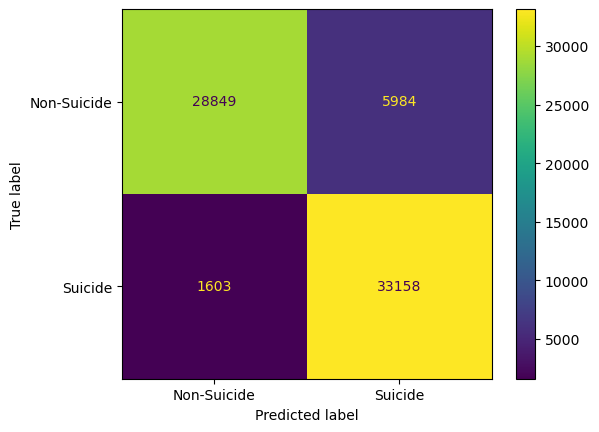

In [26]:
nb_confusion_matrix_pos = metrics.confusion_matrix(test_y_pos, y_pred_nb_pos)

nb_cm_display_pos = metrics.ConfusionMatrixDisplay(confusion_matrix = nb_confusion_matrix_pos, display_labels = ["Non-Suicide", "Suicide"])

nb_cm_display_pos.plot()
plt.show()

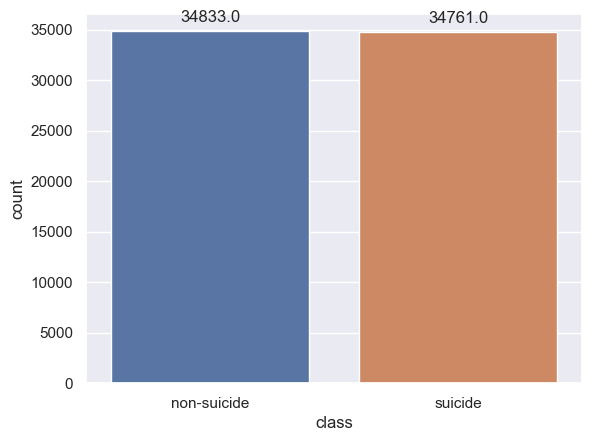

In [27]:
sns.set(style="darkgrid")
ax = sns.countplot(x=test_y_pos)

for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()


### Sentiment Analysis

In [28]:
#Naive Bayes Classifier
naive_bayes_classifier_sa = MultinomialNB()
naive_bayes_classifier_sa.fit(train_X_sa, train_y_sa)
#predicted y
y_pred_nb_sa = naive_bayes_classifier_sa.predict(test_X_sa)

In [29]:
print(metrics.classification_report(test_y_sa, y_pred_nb_sa, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.95      0.84      0.89     34833
     Suicide       0.86      0.95      0.90     34761

    accuracy                           0.90     69594
   macro avg       0.90      0.90      0.90     69594
weighted avg       0.90      0.90      0.90     69594



In [30]:
nb_accuracy_sa = accuracy_score(y_pred_nb_sa, test_y_sa)
print("Naive Bayes Accuracy Score -> ", nb_accuracy_sa * 100)

Naive Bayes Accuracy Score ->  89.67008650170992


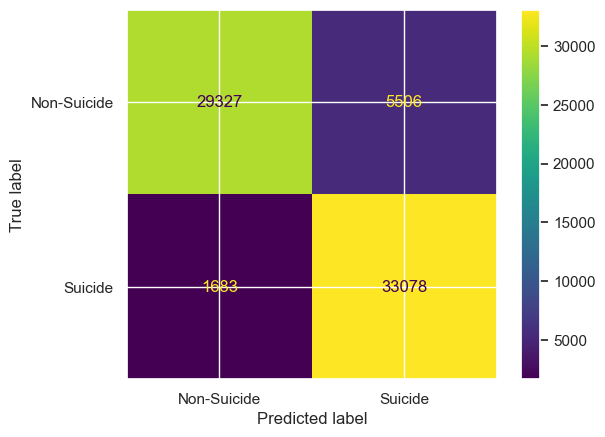

In [31]:
nb_confusion_matrix_sa = metrics.confusion_matrix(test_y_sa, y_pred_nb_sa)

nb_cm_display_sa = metrics.ConfusionMatrixDisplay(confusion_matrix = nb_confusion_matrix_sa, display_labels = ["Non-Suicide", "Suicide"])

nb_cm_display_sa.plot()
plt.show()

## Logistic Regression

### POS_TAG + Domain_Dictionary

In [32]:
# fit the training dataset on the Logistic Regression classifier
logreg_pos = LogisticRegression(max_iter=200)
logreg_pos.fit(X_train_tf_pos,train_y_pos)
# predict the labels on validation dataset
y_pred_logreg_pos = logreg_pos.predict(X_test_tf_pos)

In [33]:
print(metrics.classification_report(test_y_pos, y_pred_logreg_pos, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.93      0.95      0.94     34833
     Suicide       0.94      0.93      0.94     34761

    accuracy                           0.94     69594
   macro avg       0.94      0.94      0.94     69594
weighted avg       0.94      0.94      0.94     69594



In [34]:
logreg_accuracy_pos = accuracy_score(y_pred_logreg_pos, test_y_pos)
print("Logistic Regression Accuracy Score -> ", logreg_accuracy_pos * 100)

Logistic Regression Accuracy Score ->  93.57846940828233


In [35]:
#Log Reg Confusion Matrix
print("Logistic Regression Confusion Matrix:")
print(metrics.confusion_matrix(test_y_pos, y_pred_logreg_pos))

Logistic Regression Confusion Matrix:
[[32941  1892]
 [ 2577 32184]]


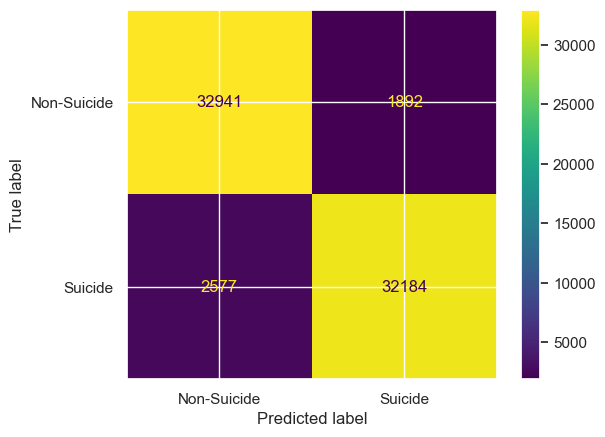

In [36]:
logreg_confusion_matrix_pos = metrics.confusion_matrix(test_y_pos, y_pred_logreg_pos)

logreg_cm_display_pos = metrics.ConfusionMatrixDisplay(confusion_matrix = logreg_confusion_matrix_pos, display_labels = ["Non-Suicide", "Suicide"])

logreg_cm_display_pos.plot()
plt.show()

In [ ]:
#### Hyperparameter tuning

# Create a logistic regression object
lr = LogisticRegression(max_iter=10000)

# Define the parameter distributions to search over
param_distributions = {
    'penalty': ['l1', 'l2'],
    'C': loguniform(0.01, 100),
    'solver': ['liblinear', 'saga','newton-cg','lbfgs']
}

# Create a randomized search object
random_search_pos = RandomizedSearchCV(estimator=lr, param_distributions=param_distributions, n_iter=20, cv=5, scoring='accuracy')

# Fit the randomized search to the data
random_search_pos.fit(X_train_tf_pos, train_y_pos)

# Print the best hyperparameters and the best score
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

### Sentiment Analysis

In [37]:
# fit the training dataset on the Logistic Regression classifier
logreg_sa = LogisticRegression(max_iter=200)
logreg_sa.fit(train_X_sa,train_y_sa)
# predict the labels on validation dataset
y_pred_logreg_sa = logreg_sa.predict(test_X_sa)

In [38]:
print(metrics.classification_report(test_y_sa, y_pred_logreg_sa, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.93      0.94      0.94     34833
     Suicide       0.94      0.93      0.93     34761

    accuracy                           0.94     69594
   macro avg       0.94      0.94      0.94     69594
weighted avg       0.94      0.94      0.94     69594



In [39]:
logreg_accuracy_sa = accuracy_score(y_pred_logreg_sa, test_y_sa)
print("Logistic Regression Accuracy Score -> ", logreg_accuracy_sa * 100)

Logistic Regression Accuracy Score ->  93.52961462195016


In [40]:
#Log Reg Confusion Matrix
print("Logistic Regression Confusion Matrix:")
print(metrics.confusion_matrix(test_y_sa, y_pred_logreg_sa))

Logistic Regression Confusion Matrix:
[[32912  1921]
 [ 2582 32179]]


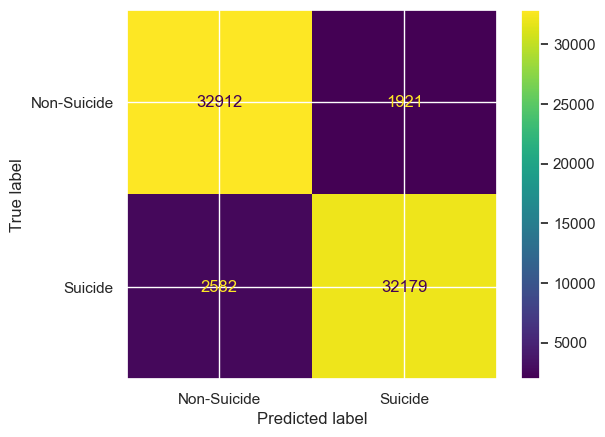

In [41]:
lr_confusion_matrix_sa = metrics.confusion_matrix(test_y_sa, y_pred_logreg_sa)

lr_cm_display_sa = metrics.ConfusionMatrixDisplay(confusion_matrix = lr_confusion_matrix_sa, display_labels = ["Non-Suicide", "Suicide"])

lr_cm_display_sa.plot()
plt.show()

In [44]:
#### Hyperparameter tuning


# Create a logistic regression object
lr = LogisticRegression(max_iter=10000)

# Define the parameter distributions to search over
param_distributions = {
    'penalty': ['l1', 'l2'],
    'C': loguniform(0.01, 100),
    'solver': ['liblinear', 'saga','newton-cg','lbfgs']
}

# Create a randomized search object
random_search_sa = RandomizedSearchCV(estimator=lr, param_distributions=param_distributions, n_iter=20, cv=5, scoring='accuracy')

# Fit the randomized search to the data
random_search_sa.fit(train_X_sa, train_y_sa)

# Print the best hyperparameters and the best score
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

KeyboardInterrupt: 

## SVM

### POS_TAG + Domain_Dictionary

In [29]:
# fit the training dataset on the SVM classifier
linearSVC_pos = LinearSVC()
linearSVC_pos.fit(X_train_tf_pos,train_y_pos)
# predict the labels on validation dataset
y_pred_SVC_pos = linearSVC_pos.predict(X_test_tf_pos)


In [30]:
print(metrics.classification_report(test_y_pos, y_pred_SVC_pos, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.93      0.94      0.94     34833
     Suicide       0.94      0.93      0.93     34761

    accuracy                           0.94     69594
   macro avg       0.94      0.94      0.94     69594
weighted avg       0.94      0.94      0.94     69594



In [31]:
svc_accuracy_pos = accuracy_score(y_pred_SVC_pos, test_y_pos)
print("SVM Accuracy Score -> ",svc_accuracy_pos*100)

SVM Accuracy Score ->  93.52817771646981


In [32]:
#SVM Confusion Matrix
print("SVM Confusion Matrix:")
print(metrics.confusion_matrix(test_y_pos, y_pred_SVC_pos))

SVM Confusion Matrix:
[[32852  1981]
 [ 2523 32238]]


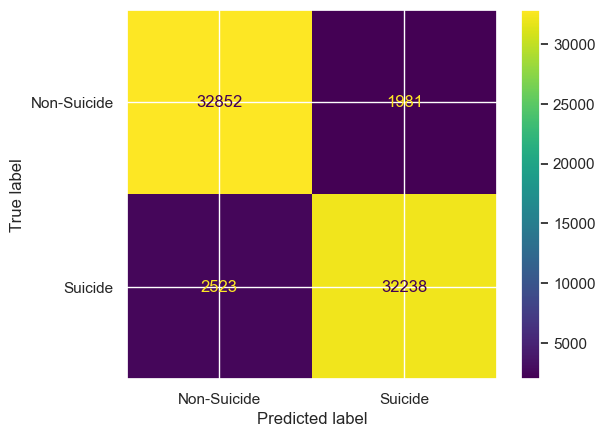

In [33]:
svc_confusion_matrix_pos = metrics.confusion_matrix(test_y_pos, y_pred_SVC_pos)

svc_cm_display_pos = metrics.ConfusionMatrixDisplay(confusion_matrix = svc_confusion_matrix_pos, display_labels = ["Non-Suicide", "Suicide"])

svc_cm_display_pos.plot()
plt.show()

### Sentiment Analysis